# Dự đoán giá nhà California với MLP tự cài đặt và các mô hình truyền thống

Notebook này thực hiện:
- Cài đặt **MLP (Multi-Layer Perceptron)** từ đầu (không dùng `sklearn.neural_network`).
- Huấn luyện trên bộ dữ liệu **California Housing**.
- So sánh kết quả với các mô hình truyền thống: **Linear Regression, Decision Tree, Random Forest**.
- Đánh giá bằng các chỉ số: **MSE, MAE, R²** và trực quan hóa kết quả.


## 1. Import thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Cài đặt MLP Regressor từ đầu (From Scratch)

Ý tưởng chính:
- Nhiều tầng ẩn (hidden layers) với hàm kích hoạt **ReLU**.
- Tầng đầu ra là **hàm tuyến tính** (phù hợp bài toán regression).
- Huấn luyện bằng **Gradient Descent** với **Backpropagation**.


In [2]:
class MLPRegressorFromScratch:
    def __init__(self, hidden_layers=(64, 32, 16), learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.loss_history = []
        
    def initialize_parameters(self, input_dim):
        """Khởi tạo weights và biases"""
        layer_dims = [input_dim] + list(self.hidden_layers) + [1]
        
        for i in range(len(layer_dims) - 1):
            # He initialization for ReLU
            w = np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2.0 / layer_dims[i])
            b = np.zeros((1, layer_dims[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Đạo hàm của ReLU"""
        return (x > 0).astype(float)
    
    def forward_propagation(self, X):
        """Forward propagation"""
        activations = [X]
        pre_activations = []
        
        # Hidden layers với ReLU
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.relu(z)
            pre_activations.append(z)
            activations.append(a)
        
        # Output layer (linear activation)
        z_output = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(z_output)
        activations.append(z_output)  # Linear activation
        
        return activations, pre_activations
    
    def compute_loss(self, y_true, y_pred):
        """Tính Mean Squared Error"""
        return np.mean((y_true - y_pred) ** 2)
    
    def backward_propagation(self, X, y, activations, pre_activations):
        m = X.shape[0]
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        # -------- Output layer --------
        dZ = 2 * (activations[-1] - y.reshape(-1, 1)) / m
        gradients_w[-1] = np.dot(activations[-2].T, dZ)
        gradients_b[-1] = np.sum(dZ, axis=0, keepdims=True)

        # -------- Hidden layers --------
        for l in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[l+1].T)
            dZ = dA * self.relu_derivative(pre_activations[l])

            gradients_w[l] = np.dot(activations[l].T, dZ)
            gradients_b[l] = np.sum(dZ, axis=0, keepdims=True)

        return gradients_w, gradients_b

    
    def update_parameters(self, gradients_w, gradients_b):
        """Cập nhật parameters sử dụng gradient descent"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]
    
    def fit(self, X, y):
        """Train model"""
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        
        # Khởi tạo parameters
        self.initialize_parameters(X.shape[1])
        
        print("Training MLP from scratch...")
        for epoch in range(self.epochs):
            # Forward propagation
            activations, pre_activations = self.forward_propagation(X)
            y_pred = activations[-1].flatten()
            
            # Tính loss
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Backward propagation
            gradients_w, gradients_b = self.backward_propagation(X, y, activations, pre_activations)
            
            # Update parameters
            self.update_parameters(gradients_w, gradients_b)
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
    
    def predict(self, X):
        """Dự đoán"""
        X = X.astype(np.float64)
        activations, _ = self.forward_propagation(X)
        return activations[-1].flatten()

## 3. Load và tiền xử lý dữ liệu California Housing

Các bước:
1. Load dataset bằng `fetch_california_housing()`.
2. Tách train/test theo tỉ lệ 80/20.
3. Chuẩn hóa dữ liệu đầu vào bằng `StandardScaler`.


In [3]:
print("📊 Loading California Housing dataset...")
housing = fetch_california_housing()
X = housing.data
y = housing.target

print(f"Dataset shape: {X.shape}")
print(f"Target range: ${y.min():.2f} - ${y.max():.2f} (in $100,000s)")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data preprocessed: {X_train.shape[0]} training, {X_test.shape[0]} test samples")

📊 Loading California Housing dataset...
Dataset shape: (20640, 8)
Target range: $0.15 - $5.00 (in $100,000s)
✅ Data preprocessed: 16512 training, 4128 test samples


## 4. Huấn luyện MLP (From Scratch)

- Sử dụng kiến trúc: **32 → 16 → 8** neuron ẩn.
- Số epoch: **200**, learning rate: **0.001**.


In [4]:
print("\n🧠 Training MLP from Scratch...")
mlp_scratch = MLPRegressorFromScratch(
    hidden_layers=(32, 16, 8),  # Smaller network for stability
    learning_rate=0.001,
    epochs=200
)

mlp_scratch.fit(X_train_scaled, y_train)

# Đánh giá trên tập test
y_pred_mlp_scratch = mlp_scratch.predict(X_test_scaled)

mse_mlp_scratch = mean_squared_error(y_test, y_pred_mlp_scratch)
mae_mlp_scratch = mean_absolute_error(y_test, y_pred_mlp_scratch)
r2_mlp_scratch = r2_score(y_test, y_pred_mlp_scratch)

print(f"\n📈 MLP FROM SCRATCH Results:")
print(f"   MSE: {mse_mlp_scratch:.4f}")
print(f"   MAE: {mae_mlp_scratch:.4f}")
print(f"   R²:  {r2_mlp_scratch:.4f}")


🧠 Training MLP from Scratch...
Training MLP from scratch...
Epoch 0: Loss = 7.6409
Epoch 20: Loss = 4.9246
Epoch 40: Loss = 3.6977
Epoch 60: Loss = 2.9249
Epoch 80: Loss = 2.3788
Epoch 100: Loss = 2.0079
Epoch 120: Loss = 1.7648
Epoch 140: Loss = 1.5959
Epoch 160: Loss = 1.4679
Epoch 180: Loss = 1.3654

📈 MLP FROM SCRATCH Results:
   MSE: 1.3887
   MAE: 0.8293
   R²:  -0.0597


## 5. So sánh với các mô hình truyền thống

Các mô hình được dùng để so sánh:
- **Linear Regression**
- **Decision Tree Regressor**
- **Random Forest Regressor**

Mục tiêu: xem MLP tự cài đặt đứng ở đâu so với các mô hình phổ biến.


In [5]:
print("\n" + "="*60)
print("🔄 COMPARING WITH TRADITIONAL MODELS")
print("="*60)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2, 'Predictions': y_pred}
    
    print(f"   {name}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# Add MLP from scratch to results
results['MLP (Scratch)'] = {
    'MSE': mse_mlp_scratch, 
    'MAE': mae_mlp_scratch, 
    'R2': r2_mlp_scratch, 
    'Predictions': y_pred_mlp_scratch
}


🔄 COMPARING WITH TRADITIONAL MODELS

Training Linear Regression...
   Linear Regression: MSE=0.5559, MAE=0.5332, R²=0.5758

Training Decision Tree...
   Decision Tree: MSE=0.4155, MAE=0.4332, R²=0.6829

Training Random Forest...
   Random Forest: MSE=0.2965, MAE=0.3663, R²=0.7737


## 6. Trực quan hóa kết quả

- Biểu đồ **Actual vs Predicted** của MLP.
- Đồ thị **Training Loss** theo epoch.
- So sánh **MSE** và **R²** của tất cả mô hình bằng biểu đồ cột.



📊 VISUALIZING RESULTS


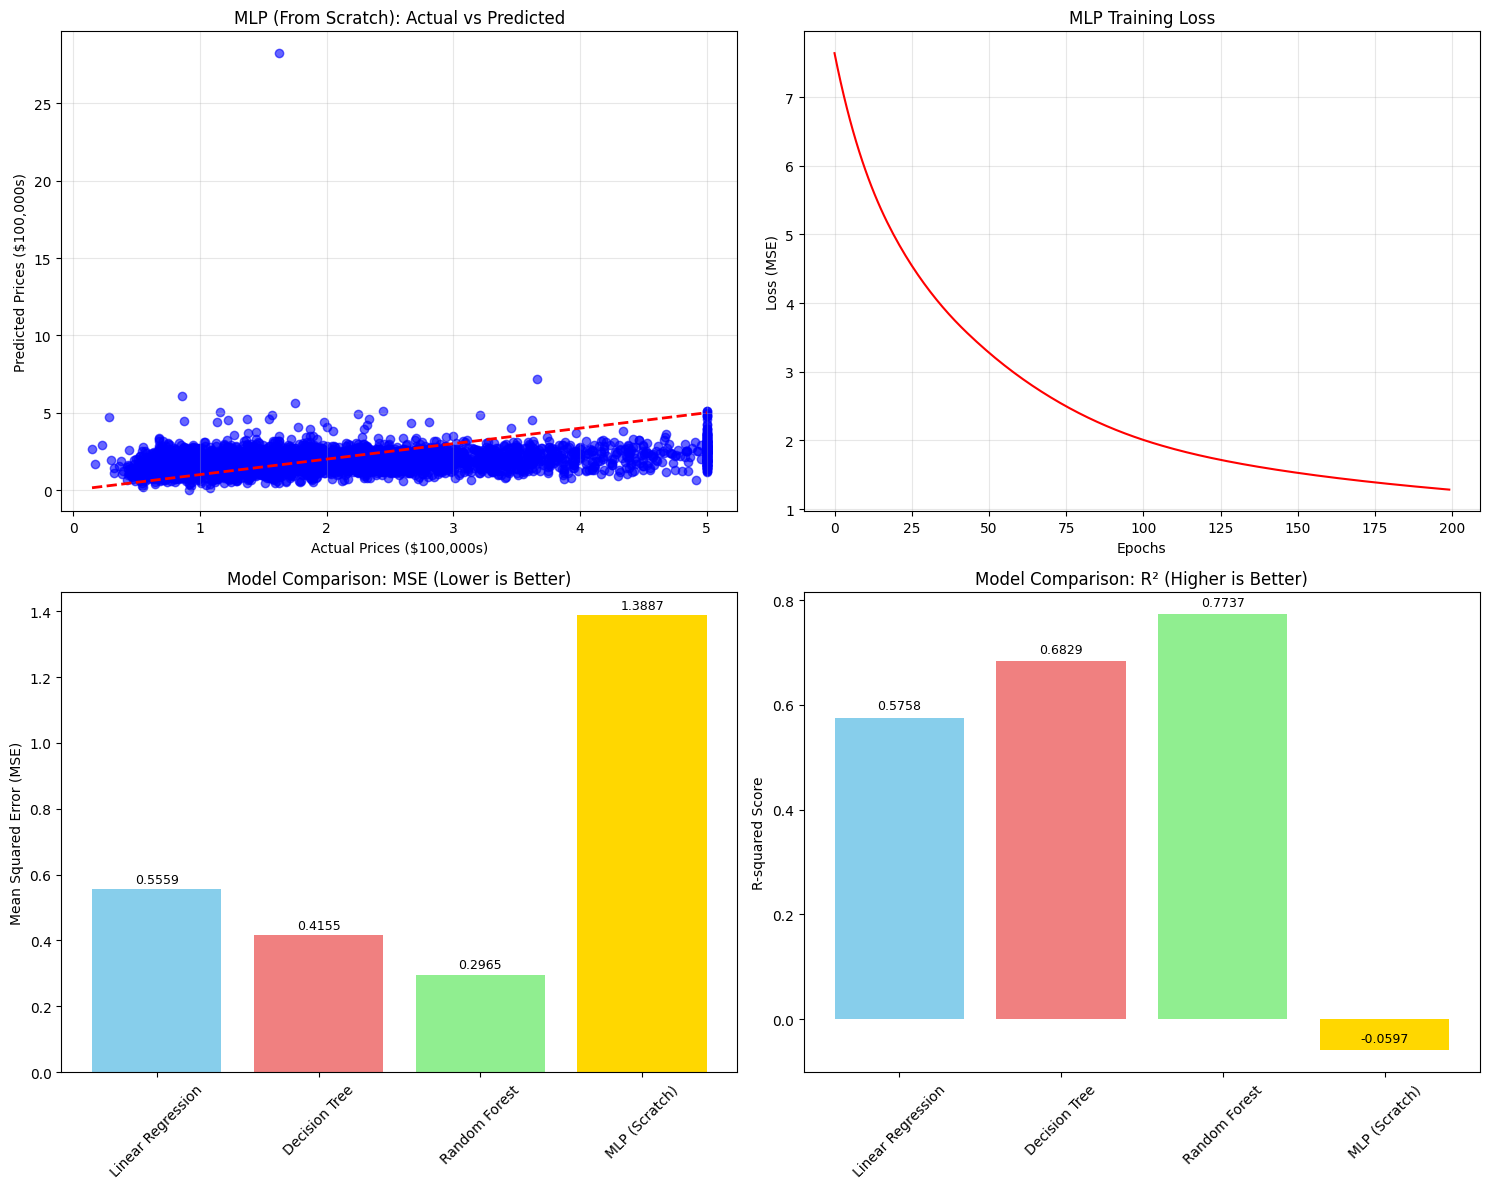

In [6]:
print("\n" + "="*60)
print("📊 VISUALIZING RESULTS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: MLP Scratch Predictions
axes[0, 0].scatter(y_test, y_pred_mlp_scratch, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Prices ($100,000s)')
axes[0, 0].set_ylabel('Predicted Prices ($100,000s)')
axes[0, 0].set_title('MLP (From Scratch): Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: MLP Training Loss
axes[0, 1].plot(mlp_scratch.loss_history, color='red')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss (MSE)')
axes[0, 1].set_title('MLP Training Loss')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: MSE Comparison
models_list = list(results.keys())
mse_values = [results[model]['MSE'] for model in models_list]
bars = axes[1, 0].bar(models_list, mse_values, 
                     color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1, 0].set_ylabel('Mean Squared Error (MSE)')
axes[1, 0].set_title('Model Comparison: MSE (Lower is Better)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, mse_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 4: R² Comparison
r2_values = [results[model]['R2'] for model in models_list]
bars = axes[1, 1].bar(models_list, r2_values, 
                     color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1, 1].set_ylabel('R-squared Score')
axes[1, 1].set_title('Model Comparison: R² (Higher is Better)')
axes[1, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, r2_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Tổng kết & phân tích

Ở đây ta tạo một bảng so sánh và chọn ra mô hình tốt nhất theo:
- **MSE thấp nhất**.
- **R² cao nhất**.

Sau đó in thử một vài giá trị dự đoán mẫu.


In [7]:
print("\n" + "="*60)
print("🎯 FINAL ANALYSIS")
print("="*60)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[model]['MSE'] for model in results],
    'MAE': [results[model]['MAE'] for model in results],
    'R2': [results[model]['R2'] for model in results]
})

print("\n📋 Model Performance Comparison:")
print(comparison_df.round(4))

# Find best models
best_mse = min(results.items(), key=lambda x: x[1]['MSE'])
best_r2 = max(results.items(), key=lambda x: x[1]['R2'])

print(f"\n🏆 Best Model by MSE: {best_mse[0]} (MSE: {best_mse[1]['MSE']:.4f})")
print(f"🏆 Best Model by R²: {best_r2[0]} (R²: {best_r2[1]['R2']:.4f})")

# Sample predictions
print(f"\n🔍 Sample Predictions (First 5):")
print(f"Actual:        {y_test[:5].round(4)}")
print(f"MLP Scratch:   {y_pred_mlp_scratch[:5].round(4)}")

print(f"\n📉 Final Training Loss: {mlp_scratch.loss_history[-1]:.4f}")

print("\n✅ MLP implemented from scratch successfully!")


🎯 FINAL ANALYSIS

📋 Model Performance Comparison:
               Model     MSE     MAE      R2
0  Linear Regression  0.5559  0.5332  0.5758
1      Decision Tree  0.4155  0.4332  0.6829
2      Random Forest  0.2965  0.3663  0.7737
3      MLP (Scratch)  1.3887  0.8293 -0.0597

🏆 Best Model by MSE: Random Forest (MSE: 0.2965)
🏆 Best Model by R²: Random Forest (R²: 0.7737)

🔍 Sample Predictions (First 5):
Actual:        [0.477 0.458 5.    2.186 2.78 ]
MLP Scratch:   [0.7466 0.9452 2.6025 1.6373 1.5532]

📉 Final Training Loss: 1.2845

✅ MLP implemented from scratch successfully!
